In [929]:
# Define if you want to download data from the original database or use the dataset one already provided and preprocessed
# Use:
# 'load': If you want to load the datase from the directory
# 'download': To download data from the database and process the images
dataset_load_method = 'load'

# Define if you want to save the dataset to a file
save_dataset = True

# Define if you want to load the trained classifiers from the directory
load_classifiers = False

# Define if you want to save the trained classifiers to a file
save_classifiers = True

# Define if you want to save classification test output to a file
save_results = True
if (save_results):
    result_output_file = open('result_output.txt','w') 

# Define if you want to print errors and warnings
enable_error_output = True

In [930]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sys import stdout
import cv2
from scipy import ndimage
from IPython.display import clear_output
from skimage.transform import resize

In [931]:
def print_percentage(prct, msg=None):
    if (prct > 100 or prct < 0):
        return
    clear_output(wait=True)
    if (msg == None):
        stdout.write("Progress: [")
    else:
        stdout.write(msg+" [")
    end = int(int(prct)/10)
    for i in range(0, end):
        stdout.write("=")
    for i in range(end, 10):
        stdout.write(" ")
    stdout.write("] "+str(prct)+"%")
    stdout.flush()

In [932]:
train_df = pd.read_csv("written_name_train_v2.csv", sep=",")
val_df = pd.read_csv("written_name_validation_v2.csv", sep=",")
test_df = pd.read_csv("written_name_test_v2.csv", sep=",")

In [933]:
def delborders(crop):
    cropf = ndimage.gaussian_filter(crop, 0.5)
    cropbin = (cropf<0.8)
    labeled, nr_objects = ndimage.label(cropbin)
    labels_to_delete = []
    for i in range(0, labeled.shape[1]):
        if (labeled[labeled.shape[0]-1][i] > 0):
            labels_to_delete.append(labeled[labeled.shape[0]-1][i])
    
    label_in_delete = False
    for x in range(0, labeled.shape[1]):
        for y in range(0, labeled.shape[0]):
            label_in_delete = False
            for l in range(0, len(labels_to_delete)):
                if (labeled[y][x] == labels_to_delete[l]):
                    label_in_delete = True
            
            if(label_in_delete):
                crop[y][x] = 1.0
    
    return crop

In [934]:
def getcrop(df, n):
    path = ""
    if df is train_df:
        path = "train_v2/train/"
    elif df is val_df:
        path = "validation_v2/validation/"
    elif df is test_df:
        path = "test_v2/test/"
    
    img = cv2.imread(path + df.iloc[n][0])
    imgh, imgw = img.shape[:-1]
    img_rgb = img.copy()
    template = cv2.imread('template(1).png')
    h, w = template.shape[:-1]

    res = cv2.matchTemplate(img_rgb, template, cv2.TM_CCOEFF_NORMED)
    threshold = .7
    loc = np.where(res >= threshold)

    if (len(loc[0])==0 and len(loc[1])==0):
        crop = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        #crop = cv2.GaussianBlur(crop,(1,1),0)
        crop = cv2.threshold(crop, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
        crop = cv2.morphologyEx(crop, cv2.MORPH_CLOSE, np.ones((1, 1), np.uint8))
        return crop, True
        
    return img, False


In [935]:
def gen_dataset(df, n:int=None):
    if (n == None):
        n = df.shape[0]
    data = []
    labels = []
    for i in range(0, n):
        crop, success = getcrop(df, i)
        if (success):
            data.append(crop)
            labels.append(df.iloc[i][1])
        else:
            if (enable_error_output):
                print("[WARNING] Template matching has failed for image: "+str(i))
        print_percentage((i*100/(n-1)), "Fetched "+str(i)+" images:")
    
    print_percentage(100, "Fetched "+str(n-1)+" images:")
    print("")
    print("Finished!")
    return data, labels

Fetched 19 images: [==========] 100%
Finished!
Training data: 7
Training labels: 7


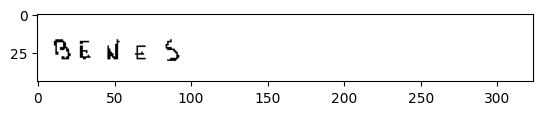

In [936]:
training_data, training_labels = gen_dataset(train_df, 20)
print("Training data: "+str(len(training_data)))
print("Training labels: "+str(len(training_labels)))

plt.imshow(training_data[0], cmap='gray')
plt.show()


In [937]:


def get_labels(crop):
    img = crop.copy() # gray-scale image

    # You could smooth the image (to remove small objects) but we saw better results without using it...
    threshold = 1

    # Find connected components
    labeled, nr_objects = ndimage.label(img<threshold) 
    #print("Number of objects is " +str(nr_objects))

    return labeled, nr_objects


In [938]:
def get_bboxes(labeled, nr_objects):
    bboxes = np.zeros((nr_objects, 2, 2), dtype='int')

    x1, y1, x2, y2 = 0, labeled.shape[0], 0, 0
    coord = 0
    cont = 0
    ytop, ybot = 0, 0
    nzero, firstb = False, False

    for x in range(0, labeled.shape[1]):
        nzero, firstb = False, False
        ytop, ybot = 0, 0
        for y in range(0, labeled.shape[0]):
            if (labeled[y][x] > 0):
                nzero = True
                if (not firstb):
                    ytop = y
                    firstb = True
                ybot = y

        if (nzero):
            if (ytop < y1):
                y1 = ytop
            if (ybot > y2):
                y2 = ybot
            if (coord == 0):
                x1 = x
                coord = 1
            elif (coord == 1):
                x2 = x
        elif ((not nzero) and (coord == 1)):
            bboxes[cont][0] = [x1, y1]
            bboxes[cont][1] = [x2, y2]
            cont += 1
            coord = 0
            x1, y1, x2, y2 = 0, labeled.shape[0], 0, 0

    bboxes = bboxes[0:cont]
    return bboxes, cont

In [939]:


def crop_characters(img, bboxes, n):
    characters = []
    for i in range(0, n):
        c = img.copy()[bboxes[i][0][1]:bboxes[i][1][1], bboxes[i][0][0]:bboxes[i][1][0]]
        if (c.shape[0] != 0 and c.shape[1] != 0):
            c = resize(c, (28, 28), mode='constant', cval=1.0, clip=True)
            characters.append((c<0.80).reshape(784))
    return characters, len(characters)



In [940]:
def labelsep(label):
    if (type(label) is str or type(label) is np.str_):
        decomposed_label = list(label)
        labels = []
        for i in range(0, len(decomposed_label)):
            if (decomposed_label[i] != ' '):
                labels.append(decomposed_label[i])
        return labels
    else:
        return []

In [941]:
def get_characters(image, label):
    labeled, nr_objects = get_labels(image)
    bboxes, n = get_bboxes(labeled, nr_objects)
    characters, n_chars = crop_characters(image, bboxes, n)
    labels = labelsep(label)
    return characters, labels[0:n_chars]

def get_characters_img_only(image):
    labeled, nr_objects = get_labels(image)
    bboxes, n = get_bboxes(labeled, nr_objects)
    characters, n_chars = crop_characters(image, bboxes, n)
    return characters

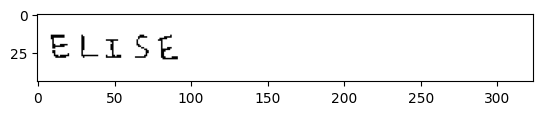

ELISE


In [942]:


selection = 3
plt.imshow(training_data[selection], cmap='gray')
plt.show()
print(training_labels[selection])



In [943]:
characters, charlabels = get_characters(training_data[selection], training_labels[selection])

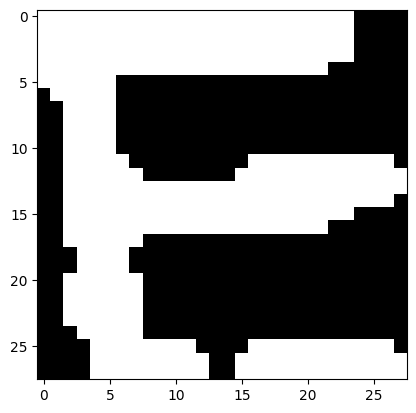

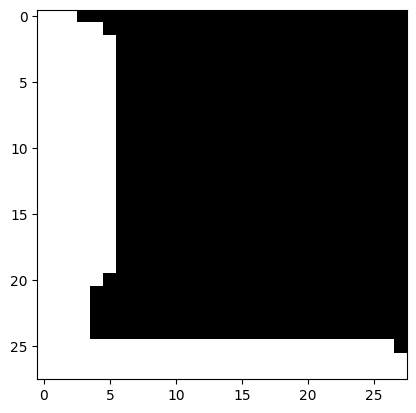

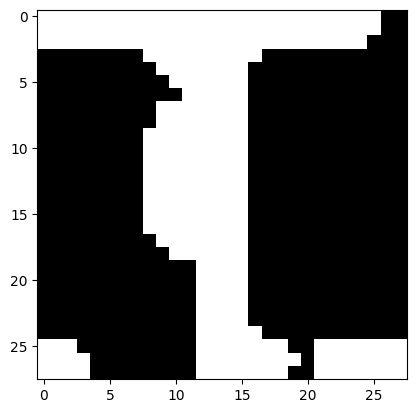

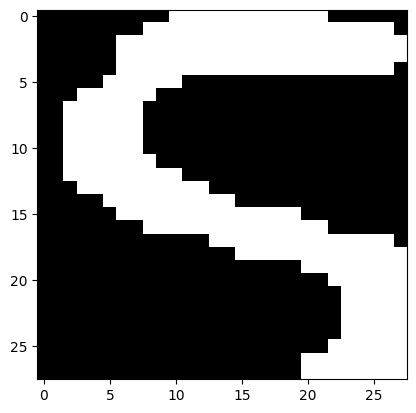

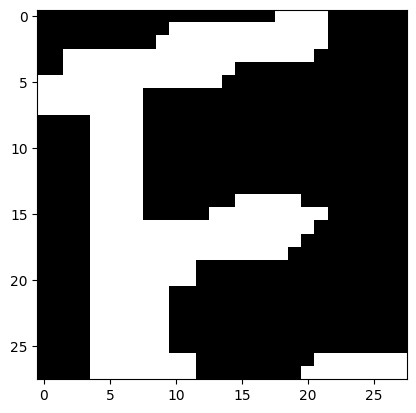

['E', 'L', 'I', 'S', 'E']


In [944]:
for i in range(0, len(characters)):
    plt.imshow(characters[i].reshape(28,28), cmap='gray')
    plt.show()
    
print(str(charlabels))